In [0]:
import pandas as pd
import sys
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from wordcloud import WordCloud
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier

%matplotlib inline

# Data preprocesing

In [0]:
news_data = pd.read_csv(r'newsCorpora.csv', sep='\t', header=None)
news_data.columns =  ['ID', 'TITLE', 'URL', 'PUBLISHER', 'CATEGORY', 'STORY', 'HOSTNAME', 'TIMESTAMP']

# EDA

Let's start EDA with missing values check.

In [0]:
news_data.apply(lambda x: x.isna().sum())

ID           0
TITLE        0
URL          0
PUBLISHER    2
CATEGORY     0
STORY        0
HOSTNAME     0
TIMESTAMP    0
dtype: int64

Since I want to apply this module to other websites Iwe don't really need publisher name. So I can leave those missing values as they are.

As we can see below there is a lot of duplicated values in columns. For most of them this is correct but it might not be for URL and TITLE. Non unique URL and TITLES might be caused by scrapper errors or multiple categories assigned to one news. I'll take care of it in outlier detection paragraph.  

In [0]:
news_data.apply(lambda x: x.duplicated(keep=False).sum())

ID                0
TITLE         29020
URL             349
PUBLISHER    420047
CATEGORY     422419
STORY        422395
HOSTNAME     419806
TIMESTAMP         0
dtype: int64

Let's take a look at publisher website types. 

In [0]:
news_data['HOST_TYPE'] = news_data['HOSTNAME'].str.split('.').apply(lambda x: x[-1])
news_data['HOST_TYPE'].value_counts().head(10)

com    349647
uk      22322
net      7343
au       6484
org      5847
ca       5495
in       3721
ie       3513
za       3492
nz       2983
Name: HOST_TYPE, dtype: int64

New publishing time analysis.

In [0]:
news_data['TIMESTAMP_FORMATED'] = pd.to_datetime(news_data['TIMESTAMP'], unit='ms')
news_data['MONTH'] = news_data['TIMESTAMP_FORMATED'].apply(lambda x: x.month)
news_data['DAY'] = news_data['TIMESTAMP_FORMATED'].apply(lambda x: x.day)
news_data['WEEKDAY'] = news_data['TIMESTAMP_FORMATED'].apply(lambda x: x.dayofweek)
news_data['HOUR'] = news_data['TIMESTAMP_FORMATED'].apply(lambda x: x.hour)

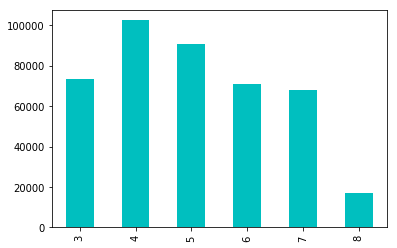

In [0]:
news_data['MONTH'].value_counts().sort_index().plot(kind='bar', color='c');

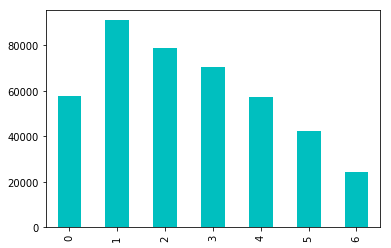

In [0]:
news_data['WEEKDAY'].value_counts().sort_index().plot(kind='bar', color='c');

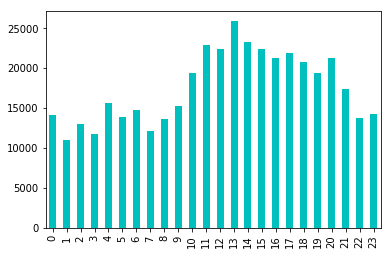

In [0]:
news_data['HOUR'].value_counts().sort_index().plot(kind='bar', color='c');

As we see the dataset is imbalanced. Depending on classification results I will decide if I need to use methods like undersampling, oversampling or less imbalance sensitive algorithms like decision trees, random forests. 

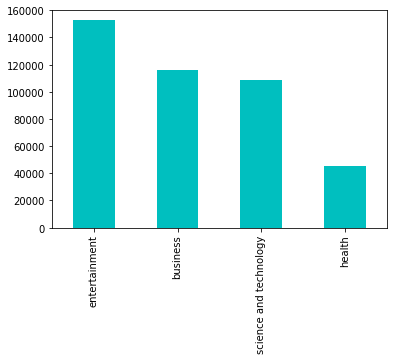

In [0]:
news_data['CATEGORY_FULL_NAME'] = news_data['CATEGORY'].replace({'b':'business', 't':'science and technology', 'e':'entertainment', 'm':'health'})
news_data['CATEGORY_FULL_NAME'].value_counts().plot(kind='bar', color='c');

# Outlier detection

In [0]:
news_data['TITLE'].value_counts().head(10)

The article requested cannot be found! Please refresh your browser or go back  ...    145
Business Highlights                                                                    59
Posted by Parvez Jabri                                                                 59
Posted by Imaduddin                                                                    53
Posted by Shoaib-ur-Rehman Siddiqui                                                    52
(click the phrases to see a list)                                                      51
Business Wire                                                                          41
PR Newswire                                                                            38
Posted by Muhammad Iqbal                                                               35
Get the Most Popular Beauty World News Stories in a Weekly Newsletter                  34
Name: TITLE, dtype: int64

It looks like there are some scrapper errors in dataset. Let's remove them.

In [0]:
news_data = news_data[~news_data['TITLE'].str.contains('^The article requested cannot be found!')]
news_data = news_data[~news_data['TITLE'].str.contains('^Posted by')]
news_data = news_data[~news_data['TITLE'].str.contains('^[\(].*[\)]$')]

Dataset contains some duplicated values let's check if one title could be assigned to few categories. 

In [0]:
duplicated_titles = news_data[news_data.duplicated(subset=['TITLE'], keep=False)]
duplicated_titles.groupby(['TITLE', 'CATEGORY'])['TITLE'].count().sort_values().head(5)

TITLE                                                                     CATEGORY
Alibaba's business model and the Chinese market make its IPO hot          b           1
UPDATE 1-New York Times publisher denies sexism, calls Abramson bad  ...  e           1
Nokia Appoints Rajeev Suri as CEO--Update                                 t           1
Nokia appoints new chief executive Rajeev Suri                            b           1
                                                                          t           1
Name: TITLE, dtype: int64

In [0]:
print(duplicated_titles.loc[duplicated_titles['TITLE'].str.contains('Nokia appoints new chief executive Rajeev Suri'), ['TITLE', 'CATEGORY']])

print(duplicated_titles.loc[duplicated_titles['TITLE'].str.contains("Alibaba's business model and the Chinese market make"), ['TITLE', 'CATEGORY']])

                                                 TITLE CATEGORY
166015  Nokia appoints new chief executive Rajeev Suri        b
166977  Nokia appoints new chief executive Rajeev Suri        t
                                                    TITLE CATEGORY
188073  Alibaba's business model and the Chinese marke...        b
193162  Alibaba's business model and the Chinese marke...        t


As we see above those news belong to more than one category so we won't remove them as duplicates. We only want to remove news duplicated by category and title.

In [0]:
news_data = news_data[~news_data.duplicated(subset=['TITLE', 'CATEGORY'], keep='first')]

# Text preprocesing

I'm going to start with lowering all characters in headlines. Next tokenize because I want to transform all "can't", "didn't" etc. into "cannot", "did not" before removing punctuation so I wont lose any information. Then I'm going to remove most common english words to get rid of noise. Finally lemmatize it means transforming word to base form. 

In [0]:
def text_cleaner(text):
    text = text.lower()
    text = word_tokenize(text)
    text = [word for word in text if word.isalpha()]
    stop_words = set(stopwords.words('english'))
    text = [w for w in text if not w in stop_words]
    
    lemmatizer=WordNetLemmatizer()
    text = [lemmatizer.lemmatize(word) for word in text]
    
    return text

In [0]:
news_data['CLEANED_TITLE'] = news_data['TITLE'].apply(lambda x: text_cleaner(x))


After text cleaning there are some empty and really long TITLES left so I will remove them.

In [0]:
news_data['LEN'] = news_data['CLEANED_TITLE'].apply(lambda x: len(x))
news_data['LEN'].value_counts().sort_index()

0         108
1         903
2        5353
3       16060
4       37669
5       64079
6       81219
7       80953
8       64081
9       37753
10      14959
11       3511
12        536
13         65
14         11
15          1
40          1
107         1
150         1
433         1
566         1
788         1
992         1
999         1
1187        1
Name: LEN, dtype: int64

In [0]:
news_data = news_data[np.logical_and(news_data['LEN'] > 0, news_data['LEN'] < 15)]

In [0]:
def create_word_cloud(news_data):
    text = " ".join(news_data["TITLE"])
    wordcloud = WordCloud().generate(text)
    plt.figure()
    plt.subplots(figsize=(20,12))
    wordcloud = WordCloud(
        background_color="white",
        max_words=len(text),
        max_font_size=40,
        relative_scaling=.5).generate(text)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

Let's check most frequent words by category.

Entertainment

<Figure size 432x288 with 0 Axes>

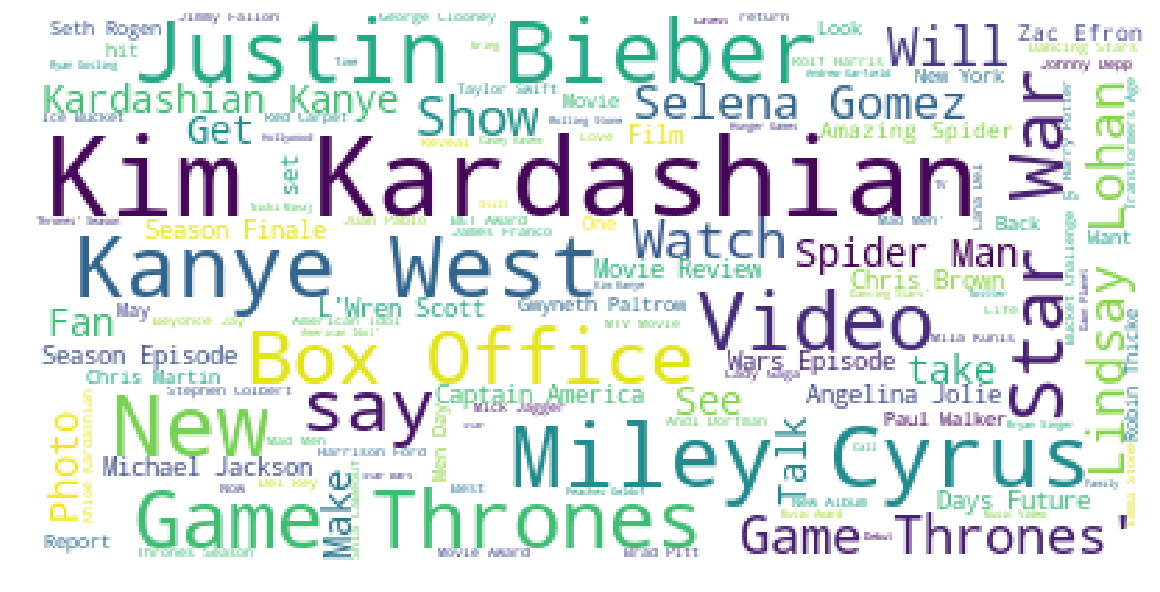

In [0]:
create_word_cloud(news_data[news_data['CATEGORY'] == 'e'])

Business

<Figure size 432x288 with 0 Axes>

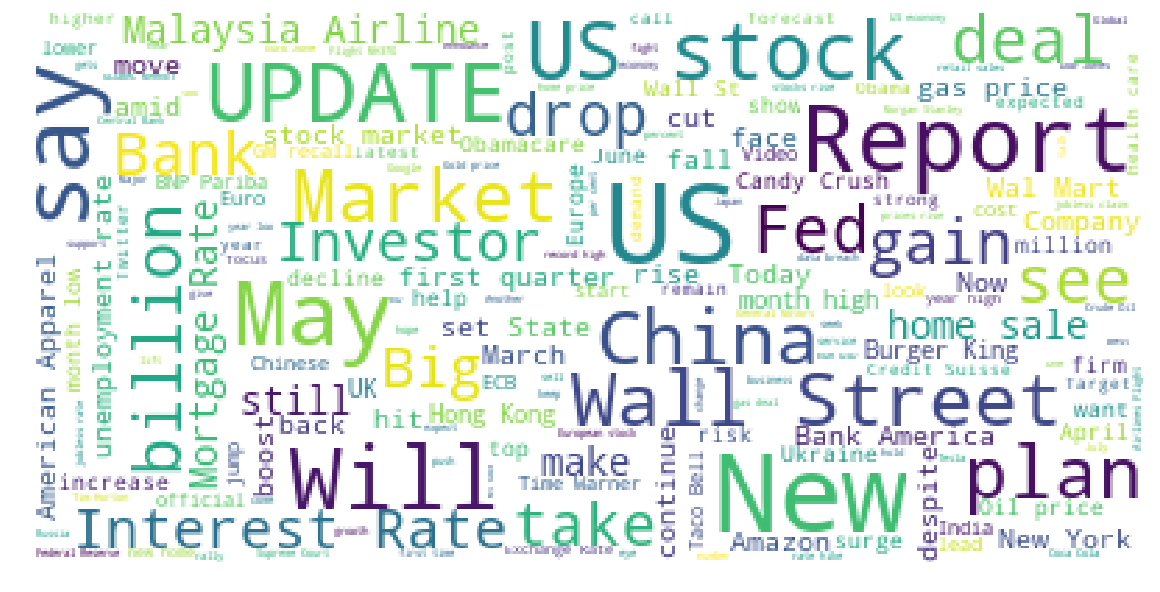

In [0]:
create_word_cloud(news_data[news_data['CATEGORY'] == 'b'])

Science and technology

<Figure size 432x288 with 0 Axes>

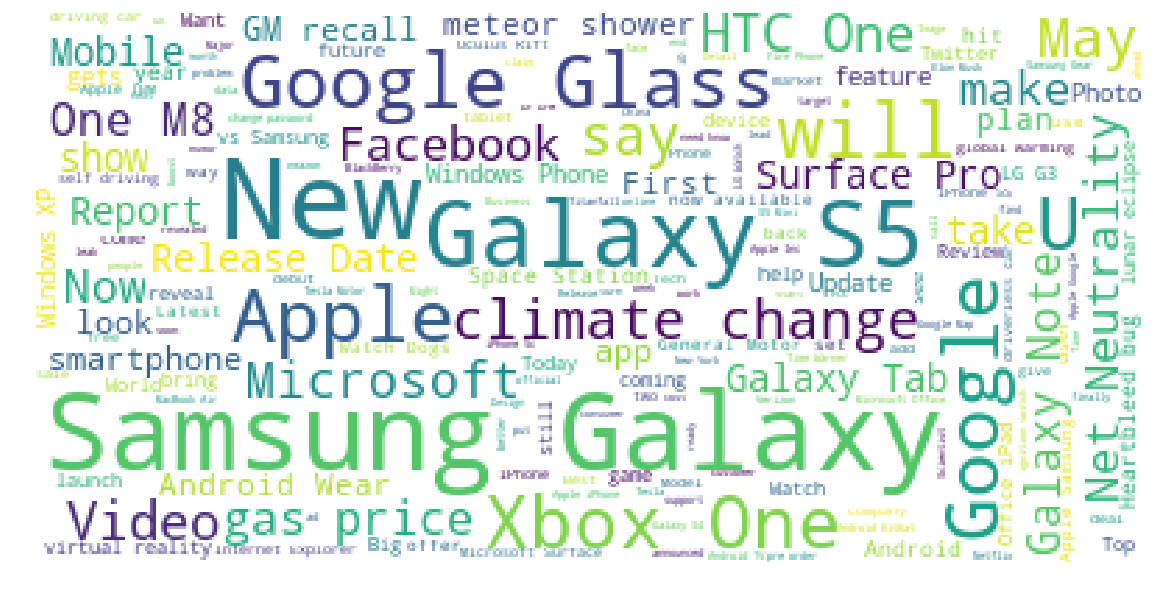

In [0]:
create_word_cloud(news_data[news_data['CATEGORY'] == 't'])

Health

<Figure size 432x288 with 0 Axes>

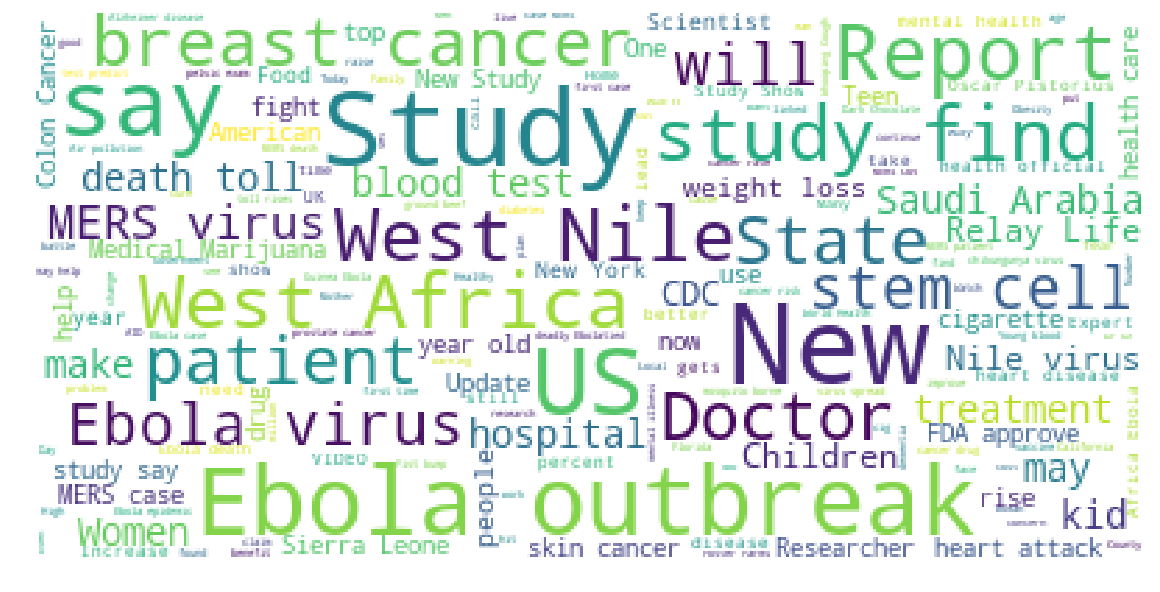

In [0]:
create_word_cloud(news_data[news_data['CATEGORY'] == 'm'])

# Classification

In [0]:
vectorizer = CountVectorizer()
x = vectorizer.fit_transform(news_data['TITLE'])

encoder = LabelEncoder()
y = encoder.fit_transform(news_data['CATEGORY'])
news_data['CATEGORY_CODE'] = y 
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

In [0]:
def create_confusion_matrix(news_data, y_test, predicted):
    aux_df = news_data[['CATEGORY', 'CATEGORY_CODE']].drop_duplicates().sort_values('CATEGORY_CODE')
    conf_matrix = confusion_matrix(y_test, predicted)
    plt.figure(figsize=(12.8,6))
    sns.heatmap(conf_matrix, 
                annot=True,
                xticklabels=aux_df['CATEGORY'].values, 
                yticklabels=aux_df['CATEGORY'].values,
                cmap="Reds")
    plt.ylabel('Predicted')
    plt.xlabel('Actual')
    plt.title('Confusion matrix')
    plt.show()

Let's start with simple Naive Bayes. I will tune hyperparameters with F1 score due to class imbalance.

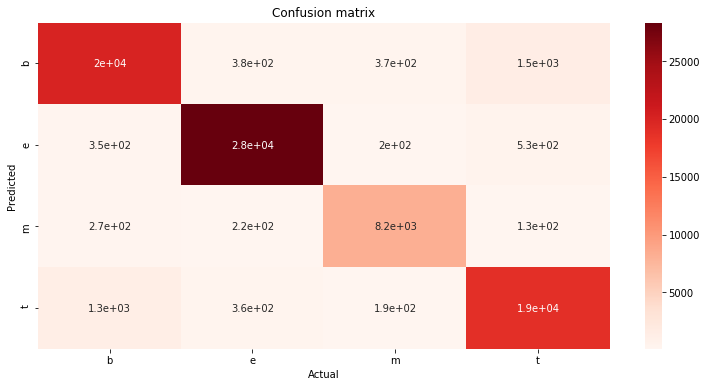

In [0]:
alpha_values = [i * 0.1 for i in range(1,11)]
max_f1_score = float('-inf')
best_alpha = None
for alpha in alpha_values:
    clf = MultinomialNB(alpha=alpha)
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    current_f1_score = f1_score(y_pred, y_test, average='micro')
    if current_f1_score > max_f1_score:
        max_f1_score = current_f1_score
        best_alpha = alpha
        
mNB = MultinomialNB(alpha=best_alpha)
mNB.fit(x_train, y_train)
cv_mNB = cross_val_score(mNB, x_test, y_test, cv=5)
np.mean(cv_mNB)

predicted_mNB = mNB.predict(x_test)
create_confusion_matrix(news_data, y_test, predicted_mNB)

In [0]:
print('Train accuracy: ' + str(mNB.score(x_train, y_train)))
print('Test accuracy: ' + str(mNB.score(x_test, y_test)) + '\n')
print(classification_report(y_test, predicted_mNB))


Train accuracy: 0.941366998136442
Test accuracy: 0.9287126524296644

              precision    recall  f1-score   support

           0       0.91      0.90      0.91     22374
           1       0.97      0.96      0.97     29396
           2       0.92      0.93      0.92      8813
           3       0.90      0.91      0.90     20848

    accuracy                           0.93     81431
   macro avg       0.92      0.93      0.92     81431
weighted avg       0.93      0.93      0.93     81431



For simple model like Naive Bayes we've got pretty good resuls.

Random migth be good try due to class imbalance.

In [0]:
rfc = RandomForestClassifier(random_state = 8, n_estimators = 30)
rfc.fit(x_train, y_train)
predicted_rfc = rfc.predict(x_test)

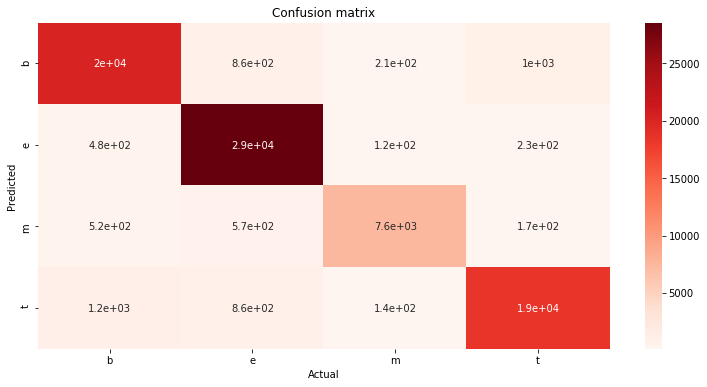

In [0]:
create_confusion_matrix(news_data, y_test, predicted_rfc)

In [0]:
print('Train accuracy: ' + str(rfc.score(x_train, y_train)))
print('Test accuracy: ' + str(rfc.score(x_test, y_test)) + '\n')
print(classification_report(y_test, predicted_rfc))

Train accuracy: 0.9976820653258464
Test accuracy: 0.9212093674399184

              precision    recall  f1-score   support

           0       0.90      0.91      0.90     22374
           1       0.93      0.97      0.95     29396
           2       0.94      0.86      0.90      8813
           3       0.93      0.89      0.91     20848

    accuracy                           0.92     81431
   macro avg       0.92      0.91      0.91     81431
weighted avg       0.92      0.92      0.92     81431



In [0]:
lr = OneVsRestClassifier(LogisticRegression())
lr.fit(x_train, y_train)

predicted_lr = lr.predict(x_test)

C:\Users\Patryk\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


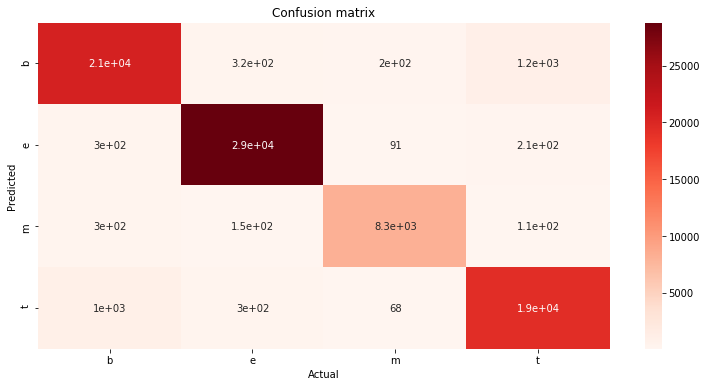

In [0]:
create_confusion_matrix(news_data, y_test, predicted_lr)

In [0]:
print('Train accuracy: ' + str(lr.score(x_train, y_train)))
print('Test accuracy: ' + str(lr.score(x_test, y_test)) + '\n')
print(classification_report(y_test, predicted_lr))

Train accuracy: 0.9644788024106521
Test accuracy: 0.9478822561432378

              precision    recall  f1-score   support

           0       0.93      0.92      0.93     22374
           1       0.97      0.98      0.98     29396
           2       0.96      0.94      0.95      8813
           3       0.93      0.93      0.93     20848

    accuracy                           0.95     81431
   macro avg       0.95      0.94      0.95     81431
weighted avg       0.95      0.95      0.95     81431



# Summary

In this project I tried 3 different models:

1.  Multinomial naive Bayes - Good starting model with high F1 score.
2.  Random forest - Possible solution for imbalance problem. Also good F1 score but looking at F1 train score we can see overfiting problem. With more hyperparameter tuning it could get better results.
3.  Logistic Regression - Best result with almost 0.95 accuracy and no hyperparameter tuning. 




 For better vector representations in future work we should consider Word2Vec or GloVe to improve algorithms accuracy.